In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Function to load MNIST data with random labels
def load_data(train_batch_size, test_batch_size):
    # Fetching training data and randomly shuffle labels
    trainset = datasets.MNIST('data', train=True, download=True, 
                              transform=transforms.Compose([
                                  transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                              ]))
    
    # Random labels for the training data
    trainset.targets = torch.tensor(np.random.randint(0, 10, len(trainset)))
    train_loader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True)

    # Load test data with correct labels
    testset = datasets.MNIST('data', train=False, 
                             transform=transforms.Compose([
                                 transforms.Resize((32, 32)),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,))
                             ]))
    test_loader = DataLoader(testset, batch_size=test_batch_size, shuffle=True)

    return train_loader, test_loader


In [3]:
# Simple CNN model 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(torch.max_pool2d(self.conv1(x), 2))
        x = torch.relu(torch.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# Training model
def train_model(model, train_loader, test_loader, optimizer, loss_fn, epochs):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        correct, total_loss = 0, 0
        
        # Training loop
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
        
        train_losses.append(total_loss / len(train_loader))
        train_accs.append(100. * correct / len(train_loader.dataset))

        # Testing loop
        model.eval()
        test_loss, correct = 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                output = model(data)
                test_loss += loss_fn(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        test_losses.append(test_loss / len(test_loader))
        test_accs.append(100. * correct / len(test_loader.dataset))

    return train_losses, test_losses, train_accs, test_accs

In [5]:
# Function to plot the results
def plot_results(train_losses, test_losses, train_accs, test_accs, epochs):
    epochs_range = range(1, epochs+1)
    
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, test_losses, label='Testing Loss')
    plt.legend(loc='upper right')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label='Training Accuracy')
    plt.plot(epochs_range, test_accs, label='Testing Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    
    plt.show()

In [6]:
# Hyperparameters and settings
train_batch_size = 64
test_batch_size = 1000
learning_rate = 0.01
epochs = 10
loss_fn = nn.CrossEntropyLoss()

In [7]:
# Load data, initialize model, and defining optimizer
train_loader, test_loader = load_data(train_batch_size, test_batch_size)
model = CNN()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)


In [8]:
# Train the model and gather results
train_losses, test_losses, train_accs, test_accs = train_model(
    model, train_loader, test_loader, optimizer, loss_fn, epochs)

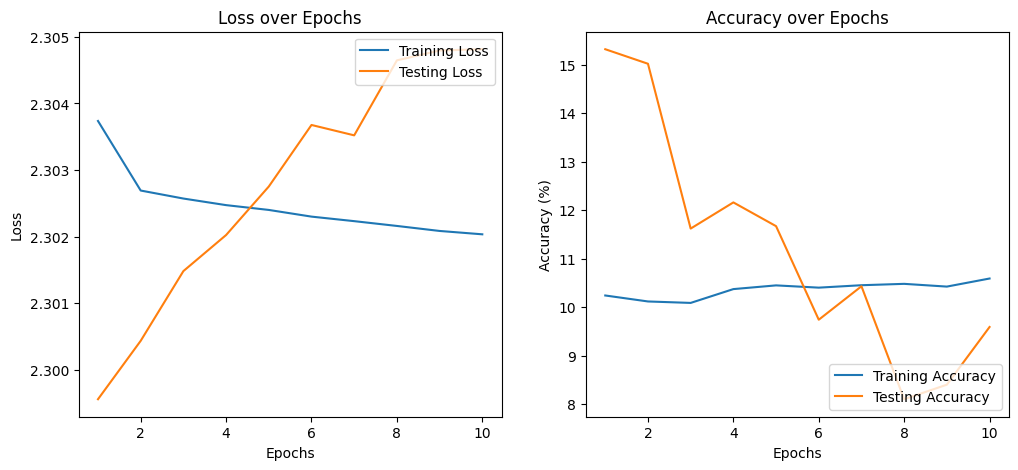

In [9]:
# Results
plot_results(train_losses, test_losses, train_accs, test_accs, epochs)